<a href="https://colab.research.google.com/github/Mainakdeb/project-jurkat/blob/main/project-jurkat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install iterative-stratification

In [76]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from albumentations import *
import torchvision.transforms as transforms
from tqdm.notebook import tnrange, tqdm
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torchvision import models 
import torch.nn as nn
import torch.optim as optim
import time
import seaborn as sns


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip

--2021-02-21 06:35:46--  https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1611429608 (1.5G) [application/zip]
Saving to: ‘BBBC048v1.zip’

BBBC048v1.zip       100%[===================>]   1.50G  19.3MB/s    in 79s     

2021-02-21 06:37:05 (19.4 MB/s) - ‘BBBC048v1.zip’ saved [1611429608/1611429608]



In [5]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst

--2021-02-21 06:37:05--  https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2955854 (2.8M)
Saving to: ‘Ground_truth.lst’

Ground_truth.lst    100%[===================>]   2.82M  9.75MB/s    in 0.3s    

2021-02-21 06:37:06 (9.75 MB/s) - ‘Ground_truth.lst’ saved [2955854/2955854]



In [6]:
!unzip "/content/BBBC048v1.zip"

Archive:  /content/BBBC048v1.zip
mapname:  conversion of  failed
 extracting: scRNA.tar.gz            
 extracting: final.tar.gz            
 extracting: CellCycle.mp4           
 extracting: CellCycle.zip           
 extracting: 1540408813.tar.gz       
 extracting: predictions.tar.gz      
 extracting: CCS_final_evaluation_scripts.tar.gz  


In [7]:
!unzip "/content/CellCycle.zip"

Streaming output truncated to the last 5000 lines.
  inflating: CellCycle/S/48668_merged.jpg  
  inflating: CellCycle/S/48674_Ch3.ome.jpg  
  inflating: CellCycle/S/48674_Ch4.ome.jpg  
  inflating: CellCycle/S/48674_Ch6.ome.jpg  
  inflating: CellCycle/S/48674_merged.jpg  
  inflating: CellCycle/S/48675_Ch3.ome.jpg  
  inflating: CellCycle/S/48675_Ch4.ome.jpg  
  inflating: CellCycle/S/48675_Ch6.ome.jpg  
  inflating: CellCycle/S/48675_merged.jpg  
 extracting: CellCycle/S/48676_Ch3.ome.jpg  
  inflating: CellCycle/S/48676_Ch4.ome.jpg  
  inflating: CellCycle/S/48676_Ch6.ome.jpg  
  inflating: CellCycle/S/48676_merged.jpg  
  inflating: CellCycle/S/4867_Ch3.ome.jpg  
  inflating: CellCycle/S/4867_Ch4.ome.jpg  
  inflating: CellCycle/S/4867_Ch6.ome.jpg  
  inflating: CellCycle/S/4867_merged.jpg  
  inflating: CellCycle/S/48688_Ch3.ome.jpg  
  inflating: CellCycle/S/48688_Ch4.ome.jpg  
  inflating: CellCycle/S/48688_Ch6.ome.jpg  
  inflating: CellCycle/S/48688_merged.jpg  
  inflating: C

In [8]:
my_file = open("/content/Ground_truth.lst", "r")
content = my_file.read()
print(type(content))
print(content[0:200])

<class 'str'>
19	0	./Anaphase/12432_Ch3.ome.jpg
8	0	./Anaphase/12432_Ch4.ome.jpg
35	0	./Anaphase/12432_Ch6.ome.jpg
36	0	./Anaphase/22004_Ch3.ome.jpg
1	0	./Anaphase/22004_Ch4.ome.jpg
42	0	./Anaphase/22004_Ch6.ome.jp


In [9]:
dataframe1 = pd.read_csv("/content/Ground_truth.lst",
                          header=None) 

In [10]:
df=dataframe1[0].str.split(expand=True)
df=df.sample(frac=1)
df

#imagefolder seems like the easier option
#does torch lightning auto mksf?


,0,1,2
66338,68471,5,./G2/568_Ch6.ome.jpg
94968,91313,6,./S/7112_Ch3.ome.jpg
43133,54883,5,./G2/10127_Ch6.ome.jpg
34810,44478,4,./G1/46078_Ch4.ome.jpg
83657,87857,6,./S/32361_Ch6.ome.jpg
...,...,...,...
41274,33056,4,./G1/8184_Ch3.ome.jpg
30960,22848,4,./G1/42025_Ch3.ome.jpg
75801,74717,6,./S/18831_Ch3.ome.jpg
21840,8392,4,./G1/32755_Ch3.ome.jpg


In [11]:
#generate csv

import os, csv

cell_df = pd.DataFrame(list())
cell_df.to_csv('cell_cycle.csv')

f=open("cell_cycle.csv",'r+')
w=csv.writer(f)

folders = ["Anaphase", "G1", "G2","Metaphase", "Prophase", "S", "Telophase"]
folders2 = ["G1","G2","S"]

for f in folders2:
  for path, dirs, files in os.walk("/content/CellCycle/"+f+"/"):
      for filename in files:
          w.writerow([path+filename, f])


In [12]:
c = pd.read_csv('./cell_cycle.csv', header=None)
c.columns = ["path","class_name"]
print(c.class_name.unique())
c

['G1' 'G2' 'S']


,path,class_name
0,/content/CellCycle/G1/44410_Ch6.ome.jpg,G1
1,/content/CellCycle/G1/49778_merged.jpg,G1
2,/content/CellCycle/G1/3853_Ch6.ome.jpg,G1
3,/content/CellCycle/G1/19185_merged.jpg,G1
4,/content/CellCycle/G1/27736_Ch3.ome.jpg,G1
...,...,...
126001,/content/CellCycle/S/42923_merged.jpg,S
126002,/content/CellCycle/S/18312_Ch6.ome.jpg,S
126003,/content/CellCycle/S/6292_merged.jpg,S
126004,/content/CellCycle/S/49358_merged.jpg,S


In [13]:
#delete non merged rows
c_merged=c[c.path.str[-10:] == "merged.jpg"]
c_merged.to_csv("cell_merged.csv")

In [14]:
def image_to_nparray(path):
    i = cv2.imread(path)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return(np.array(i))

In [15]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv, root_dir='',augmentation=None, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = csv
        self.augmentation = augmentation
        self.class_dict = {'G1':0,
                           'S': 1,
                           'G2':2}
        
    def __getitem__(self, idx): 

        smol_img_path = str(self.d.iloc[idx][1]) #image path column
        #print(smol_img_path)
        class_name = str(self.d.iloc[idx][2])  #class name column
        #print("class............",class_name)
        #print(class_name)
        full_img_path = self.root_dir + smol_img_path #+ '.png'

        #print(full_img_path)

        img_arr = image_to_nparray(full_img_path)

        if self.augmentation is not None:
            img  = self.augmentation(image = img_arr)
            img2 = img["image"]
            #print(img2)

        if self.transform is not None:
            img_ret = self.transform(img2)
            #print(img_ret)
        
        #return self.class_dict[str(class_name)], img_ret
        return {"x": img_ret,
                "y": torch.tensor(self.class_dict[str(class_name)])
        }


    def __len__(self):
      
        return (len(self.d))


In [108]:
data = C_Dataset(pd.read_csv('/content/cell_merged.csv'), 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )

size:  torch.Size([3, 128, 128])


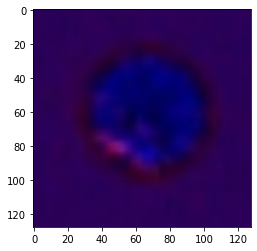

In [109]:
train_dl = torch.utils.data.DataLoader(
    data
    ,batch_size=64
    ,shuffle=True
    # ,pin_memory=True
    # ,num_workers=4
)

for data in tqdm(train_dl):
    print("size: ",data['x'][0].size())
    plt.imshow(data['x'][0].permute(1,2,0))
    plt.show()
    break

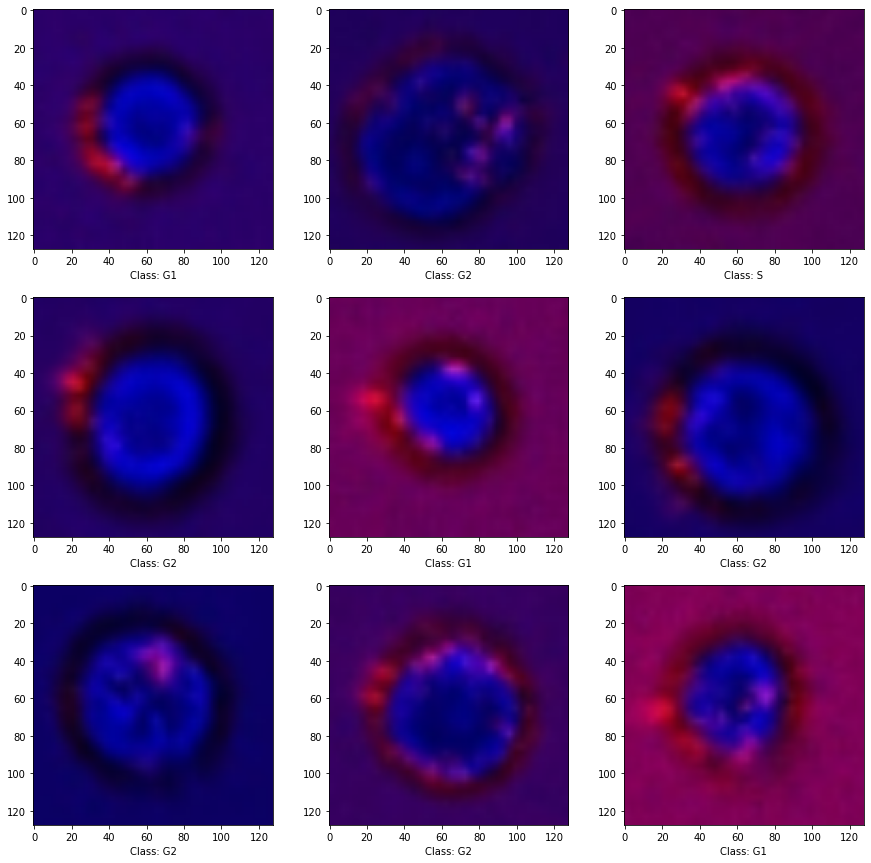

In [19]:
fig, ax = plt.subplots(3,3, figsize = (15,15))
class_dict = {'G1':0,
              'S': 1,
              'G2':2}

for i in range (9):
  batch = next(iter(train_dl))
  image, label=batch['x'],batch['y']
  #print(label)
  ax.flat[i].imshow(image[0].permute(1,2,0))
  
  text = "Class: "+list(class_dict.keys())[int(label[0])]
  ax.flat[i].set_xlabel(text)

In [106]:
#create a subset
df = pd.read_csv('/content/cell_merged.csv')
# iloc[row slicing, column slicing]
subset_df = df.iloc[0:, 1:]
subset_df.to_csv("cell_merged_subset.csv")

In [107]:
#create folds
df = pd.read_csv('/content/cell_merged_subset.csv')

df.loc[:,"kfold"] = -1

#df = df.sample(frac=1).reset_index(drop=True)

targets = df.drop("class_name", axis=1).values

NFOLDS = 10
mskf = MultilabelStratifiedKFold(n_splits = NFOLDS)
for fold, (trn, val) in enumerate(mskf.split(X=df, y = targets)):
    df.loc[val, "kfold"] = fold
    
df.to_csv("./train_targets_folds.csv", index=False)

In [103]:
train_csv = pd.read_csv('./train_targets_folds.csv')
train_csv.head()

,Unnamed: 0,path,class_name,kfold
0,0,/content/CellCycle/G1/49778_merged.jpg,G1,2
1,1,/content/CellCycle/G1/19185_merged.jpg,G1,5
2,2,/content/CellCycle/G1/26027_merged.jpg,G1,2
3,3,/content/CellCycle/G1/19613_merged.jpg,G1,1
4,4,/content/CellCycle/G1/13599_merged.jpg,G1,4


In [ ]:
#####################################
class_names = ['G1', 'S', 'G2']

'''Load a predefined model & 
   reset the fully connected layer to add dropout + 
   change the number of classes'''
torch.cuda.empty_cache()
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, len(class_names)))

'''Load model to device'''
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

'''Set evaluation criterion and optimization algorithm'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.00001)

train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

def train_model(model, criterion, optimizer, num_epochs):
  start_time = time.time()
  for epoch in range(1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch , num_epochs))
    print('-*-' * 5)
    
    # TRAINING LOOP
    train_loss = 0.0
    valid_loss = 0.0
    total_tr = 0.0
    correct_tr = 0.0
    model.train()
    for batch in train_dl:
      
      data, target=batch['x'].to(device), batch['y'].to(device)
      optimizer.zero_grad()
      # Forward Pass
      output = model(data)
      loss = criterion(output, target)
      # Backward Pass  
      loss.backward()
      # Update loss and accuracy
      optimizer.step()
      train_loss += loss.item() * data.size(0)
      _,predicted = torch.max(output.data, 1)
      total_tr += target.size(0)
      correct_tr += (predicted == target).sum().item()
        
    # VALIDATION LOOP
    model.eval()
    total_vl = 0.0
    correct_vl = 0.0
    for batch in train_dl: 
      data, target=batch['x'].to(device), batch['y'].to(device)
      # Forward Pass      
      output = model(data)   
      loss = criterion(output, target)       
      # Update loss and accuracy
      valid_loss += loss.item() * data.size(0)
      _,predicted = torch.max(output.data, 1)
      total_vl += target.size(0)
      correct_vl += (predicted == target).sum().item()
  
    # Determine and update loss averages
    train_loss = train_loss/len(train_dl.sampler)
    valid_loss = valid_loss/len(train_dl.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Determine and update mean accuracy
    tr_accuracy = (100 * correct_tr/total_tr)
    vl_accuracy = (100 * correct_vl/total_vl)
    train_accuracy.append(tr_accuracy)
    valid_accuracy.append(vl_accuracy)
    
    # Display stats for each epoch
    print('Training Loss: {:.4f} Validation Loss: {:.4f}'.format(train_loss, valid_loss))
    print('Training Accuracy: {:.4f} Validation Accuracy: {:.4f}'.format( tr_accuracy, vl_accuracy))

  time_elapsed = time.time() - start_time
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  return model
model = train_model(model, criterion, optimizer, num_epochs=30)

In [ ]:
class Engine:
  #something wrong here
      def __init__(self, model, optimizer, device, scheduler):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler

      @staticmethod
      def loss_fn(targets, outputs):
        return nn.CrossEntropyLoss() (outputs, targets)

      def train(self, data_loader):
        self.model.train()
        final_loss=0
        total_tr = 0.0
        correct_tr = 0.0
        for data in tqdm(data_loader):
            self.optimizer.zero_grad()
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            total_tr += targets.size(0)
            outputs = self.model(inputs)
            # print(outputs)
            # print("targets:", targets)
            loss = self.loss_fn(targets, outputs)
            loss.backward()
            
            self.optimizer.step()
            
            final_loss += loss.item()
            _,predicted = torch.max(outputs.data, 1)
            correct_tr += (predicted == targets).sum().item()

        self.scheduler.step(1.)
        tr_accuracy = (100 * correct_tr/total_tr)
        return(final_loss, tr_accuracy)


      def evaluate(self, data_loader):
        self.model.train()
        final_loss=0
        for data in data_loader:
            #self.optimizer.zero_grad()
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(targets, outputs)
            #loss.backward()
            #self.optimizer.step()
            final_loss += loss.item()
        return(final_loss))


In [112]:
def run_training(fold, batch_size, lr, save_model=True, num_epochs = 69):

    val_fold=train_csv[train_csv['kfold'] == fold]
    train_fold=train_csv[train_csv['kfold'] != fold]
    
    
    train_dataset = C_Dataset(train_fold, 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )
    valid_dataset = C_Dataset(val_fold, 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )
    
    train_loader = torch.utils.data.DataLoader(
                    train_dataset
                    ,batch_size=batch_size
                    ,shuffle=False
                )

    val_loader = torch.utils.data.DataLoader(
                    valid_dataset
                    ,batch_size=256
                    ,shuffle=False
                )

    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, 3))
    model = model_ft.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.00001)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1,
                                                 patience=7, 
                                                 eps=1e-4, 
                                                 verbose=True)
    criterion = nn.CrossEntropyLoss() 
    eng = Engine(model, optimizer, device='cuda', scheduler = scheduler)
    
    best_loss = 999
    early_stop_iter = 10
    early_stop_count=0

    for epoch in tnrange(num_epochs):
        train_loss, train_accuracy = eng.train(train_loader)
        valid_loss = eng.evaluate(val_loader)
        print("train_loss:", train_loss, "val_loss:", valid_loss, "train_acc: ", train_accuracy)
        if valid_loss<best_loss:
            best_loss = valid_loss
            if save_model:
                torch.save(model.state_dict(), "model_"+str(fold)+".pth")
        else:
            early_stop_count +=1
            
        if early_stop_count>early_stop_iter:
            break
                    
    return(best_loss)
    #to do: accuracy

In [ ]:
best_losses = []
for fold in range(NFOLDS):
    best_losses.append(
        run_training(
            fold=fold,
            batch_size = 64,#best_params["batch_size"],
            lr = 0.0001,#best_params["lr"],
            num_epochs = 20
        )
    )

In [83]:
data_sub = C_Dataset(pd.read_csv('/content/cell_merged_subset.csv'), 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )

train_dl_sub = torch.utils.data.DataLoader(
    data_sub
    ,batch_size=64
    ,shuffle=True
    # ,pin_memory=True
    # ,num_workers=4
)

In [85]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, 3))
model = model_ft.to(device)
model.load_state_dict(torch.load("model_0.pth"))

<All keys matched successfully>

In [ ]:
class_names =  ['G1', 'S', 'G2']
confusion_matrix = torch.zeros(len(class_names), len(class_names))

with torch.no_grad():
    for i, data in enumerate(train_dl_sub, 0):
        images, labels = data['x'], data['y']
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

cm = confusion_matrix.numpy()
fig = plt.figure(figsize=(6.5,6),  dpi = 80)
ax = sns.heatmap(cm,
                 annot=True, 
                 cmap='Blues', 
                 xticklabels = class_names, 
                 yticklabels = class_names, 
                 fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [48]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
loss = loss(input, target)
loss

tensor(1.7658, grad_fn=<NllLossBackward>)

In [49]:
input

tensor([[ 1.1859,  0.3205,  1.5585, -0.2845,  1.1461],
        [ 0.8449, -0.3966, -0.3360,  0.3838, -1.3419],
        [ 1.2844,  0.1489,  0.9319,  1.2537,  1.5205]], requires_grad=True)

In [50]:
target

tensor([0, 3, 1])